<a href="https://colab.research.google.com/github/DanDas3/reconhecimento-digitos/blob/master/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
!pip install --upgrade opencv-python
!pip install --upgrade numpy

Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.1.1.26)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.17.4)


In [0]:
#coding: utf-8
import cv2 as cv
import numpy as np
import imutils
import os
import keras #Rede Neural
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from matplotlib import pyplot as plt
from getpass import getpass
from os import listdir
from os.path import isfile, join

In [0]:
root = "reconhecimento-digitos"
data_root = "data"
out_path_root = "output"
digits_trains = "cvl-single-digits-train-validation/train"
digits_eval = "cvl-single-digits-train-validation/valid"
digits_valid = "cvl-single-digits-completeDatabase/cvl-single-digits/valid/"
string_trains = "cvl-strings-train/train"
string_eval = "cvl-strings-eval/cvl-strings-eval"

In [0]:
if os.path.exists(root) == False:
  !git clone https://github.com/DanDas3/reconhecimento-digitos.git

In [0]:
# Funções

def carregaImagem(image):
    return cv.imread(image)

def formataTag(tag):
    num = tag.split("-", 1)[0]
    return [t for t in num]

def filtroGaussiano(img):
    return cv.GaussianBlur(img, (5, 5),0)

def binarizacao(img):
    max_value = 255
    neighborhood_size=99
    subtract_from_mean = 10
    return cv.adaptiveThreshold(cv.cvtColor(img, cv.COLOR_BGR2GRAY), max_value, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, neighborhood_size, subtract_from_mean)
    #return cv.threshold(img, 230, 255, cv.THRESH_BINARY_INV)[1]

def filtroMorfologico(img):
    return cv.erode(img, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,1)), iterations=1)

def encontrarContornos(img):
    cnts = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts

def ordenarContornos(cnts):
    for i in range(len(cnts)):
        for j in range(i+1,len(cnts)):
            x_i = cv.boundingRect(cnts[i])[0]
            x_j = cv.boundingRect(cnts[j])[0]

            if(x_j < x_i):
                aux = cnts[j]
                cnts[j] = cnts[i]
                cnts[i] = aux
    return cnts
def extrairDadosContorno(cnts):
    dados = []

    for c in cnts:
        x, y, w, h = cv.boundingRect(c)
        dados.append((x,y,w,h))
    return dados

def trataContornos(dadosContorno):
    dados_novo = []
    for c in dadosContorno:
        x = c[0]
        y = c[1]
        w = c[2] # width
        h = c[3] # height
        if w >= 5 and h >= 17:
            if (w >= 53):  # Divide a região em duas
                dados_novo.append((x, y, w//2, h))
                dados_novo.append((x+w//2, y, w//2, h))
            else:
                dados_novo.append((x, y, w, h))
    return dados_novo
def marcarContorno(img, pos):
    #recorte = []
    final = img.copy()
    for p in pos:
        # dados do contorno
        (x, y, w, h) = p
        cv.rectangle(final, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return final

def extrairDigitos(img, pos):
    digitos = []
    for p in pos:
        # dados do contorno
        (x, y, w, h) = p
        i = img[y:y + h, x:x + w]
        i = cv.resize(i, (32, 32))
        digitos.append(i)
        #cv.rectangle(final, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return digitos

def carregaDigitTrain():
  path = root + "/" + data_root + "/" + digits_trains + "/"
  images = [f for f in listdir(path) if isfile(join(path, f))]
  imgBin = 0
  size_vector = 32*32
  data = np.ndarray((len(images), 32, 32, 3))
  data_vector = np.ndarray((len(images), size_vector))
  tags = np.ndarray((len(images), 1))

  for i in range(len(images)):
    img = cv.imread(path + images[i])
    img = cv.resize(img,(32,32))
    imgBin = binarizacao(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    tags[i] = images[i][:1]
    data[i] = img
    data_vector[i] = imgBin.flatten()
  return data, data_vector, tags

def carregaDigitEval():
  path = root + "/" + data_root + "/" + digits_eval + "/"
  images = [f for f in listdir(path) if isfile(join(path, f))]
  imgBin = 0
  size_vector = 32*32
  data = np.ndarray((len(images), 32, 32, 3))
  data_vector = np.ndarray((len(images), size_vector))
  tags = np.ndarray((len(images), 1))
  for i in range(len(images)):
    img = cv.imread(path + images[i])
    img = cv.resize(img,(32,32))
    imgBin = binarizacao(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    tags[i] = images[i][:1]
    data[i] = img
    data_vector[i] = imgBin.flatten()
  return data, data_vector, tags

def carregaDigitValid():
  path = root + "/" + data_root + "/" + digits_valid + "/"
  images = [f for f in listdir(path) if isfile(join(path, f))]
  imgBin = 0
  size_vector = 32*32
  data = np.ndarray((len(images), 32, 32, 3))
  data_vector = np.ndarray((len(images), size_vector))
  tags = np.ndarray((len(images), 1))
  for i in range(len(images)):
    img = cv.imread(path + images[i])
    img = cv.resize(img,(32,32))
    imgBin = binarizacao(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    tags[i] = images[i][:1]
    data[i] = img
    data_vector[i] = imgBin.flatten()
  return data, data_vector, tags

def carregaStringsValid():
  path = root + "/" + data_root + "/" + string_eval + "/"
  images = [f for f in listdir(path) if isfile(join(path, f))]
  #data = np.ndarray((len(images), 365, 32, 3))
  #tags = np.ndarray((len(images), 1))
  data = []
  digits = []
  for i in range(len(images)):
    img = cv.imread(path + images[i],0)
    #img = cv.resize(img,(365,89))    
    tag_num = images[i].split("-",1)[0]
    for j in range(len(tag_num)):
      digits.append(tag_num[j])
    data.append((img, digits))  
    #tags[i] = int(tag_num)
    #data[i] = img
  
  return data

In [173]:
data_train, x_train, tag_train = carregaDigitTrain()

data_eval, x_eval, tag_eval = carregaDigitEval()

data_valid, x_valid, tag_valid = carregaDigitValid()

print(type(tag_train))
print(type(tag_train[0]))
print(tag_train[0])

# string_digits=carregaStringsValid()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[6.]


In [0]:
#Normaliza
x_train /= 255
x_eval /= 255
x_valid /= 255

In [175]:
# Organiza a categoria
num_classes = len(np.unique(tag_train))
print("Número de classes:", num_classes)

tag_train = keras.utils.to_categorical(tag_train, num_classes)
tag_valid = keras.utils.to_categorical(tag_valid, num_classes)
tag_eval = keras.utils.to_categorical(tag_eval, num_classes)

Número de classes: 10


In [0]:
# carregando as imagens
data = []
for image in images:
    #i = cv.imread(path + image, 0)
    img = carregaImagem(path + image)
    tag = formataTag(image)
    blur = filtroGaussiano(img)
    binImg = binarizacao(blur)
    binImg = filtroMorfologico(binImg)
    cnts = encontrarContornos(binImg)
    cnts = ordenarContornos(cnts)
    pos = extrairDadosContorno(cnts)
    pos = trataContornos(pos)
    marcado = marcarContorno(img.copy(), pos)
    digitos = extrairDigitos(img, pos)
    data.append((img, blur, binImg, cnts, pos, marcado, digitos, tag))

['4', '1', '2', '2', '5', '8']


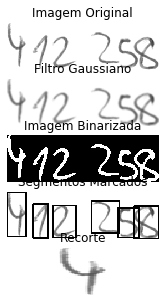

In [177]:
(img, blur, binImg, cnts, pos, marcado, digitos, tag) = data[24]

fig,axes = plt.subplots(5, 1, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(cv.cvtColor(img, cv.COLOR_GRAY2BGR))
ax[0].set_title("Imagem Original")
ax[0].set_axis_off()

ax[1].imshow(cv.cvtColor(blur, cv.COLOR_GRAY2BGR))
ax[1].set_title("Filtro Gaussiano")
ax[1].set_axis_off()

ax[2].imshow(cv.cvtColor(binImg, cv.COLOR_GRAY2RGB))
ax[2].set_title("Imagem Binarizada")
ax[2].set_axis_off()

ax[3].imshow(cv.cvtColor(marcado, cv.COLOR_BGR2RGB))
ax[3].set_title("Segmentos Marcados")
ax[3].set_axis_off()

ax[4].imshow(cv.cvtColor(digitos[0], cv.COLOR_BGR2RGB))
ax[4].set_title("Recorte")
ax[4].set_axis_off()

print(tag)

# Criação e treinamento da MLP

In [178]:
# Modelagem da MLP
mlp = Sequential()
mlp.add(Dense(512, input_shape=(1024,))) # entrada com imagens 32x32 -> vetor de 1024 posições, primeira camada com 512 neurônios
mlp.add(Activation("relu"))
mlp.add(Dropout(0.2))

mlp.add(Dense(512))
mlp.add(Activation("relu"))
mlp.add(Dropout(0.2))

mlp.add(Dense(10)) # Saída com 10 posições referentes as classes
mlp.add(Activation("softmax"))
mlp.add(Dropout(0.2))

mlp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [0]:
# Compilando
mlp.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Train on 7000 samples, validate on 7000 samples
Epoch 1/50
 - 1s - loss: 3.6973 - acc: 0.6479 - val_loss: 0.4248 - val_acc: 0.8709

Epoch 00001: val_loss improved from inf to 0.42481, saving model to model.weights.best.hdf5
Epoch 2/50
 - 0s - loss: 3.3692 - acc: 0.7366 - val_loss: 0.3443 - val_acc: 0.8950

Epoch 00002: val_loss improved from 0.42481 to 0.34428, saving model to model.weights.best.hdf5
Epoch 3/50
 - 0s - loss: 3.4053 - acc: 0.7487 - val_loss: 0.3396 - val_acc: 0.8977

Epoch 00003: val_loss improved from 0.34428 to 0.33962, saving model to model.weights.best.hdf5
Epoch 4/50
 - 0s - loss: 3.3214 - acc: 0.7650 - val_loss: 0.3090 - val_acc: 0.9077

Epoch 00004: val_loss improved from 0.33962 to 0.30897, saving model to model.weights.best.hdf5
Epoch 5/50
 - 0s - loss: 3.1197 - acc: 0.7843 - val_loss: 0.3030 - val_acc: 0.9126

Epoch 00005: val_loss improved from 0.30897 to 0.30305, saving model to model.weights.best.hdf5
Epoch 6/50
 - 0s - loss: 3.3195 - acc: 0.7756 - val_loss

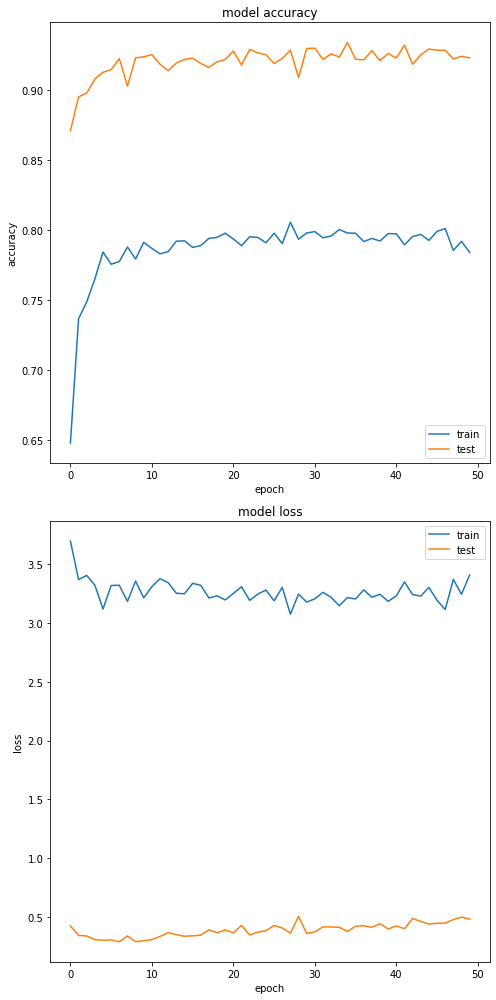

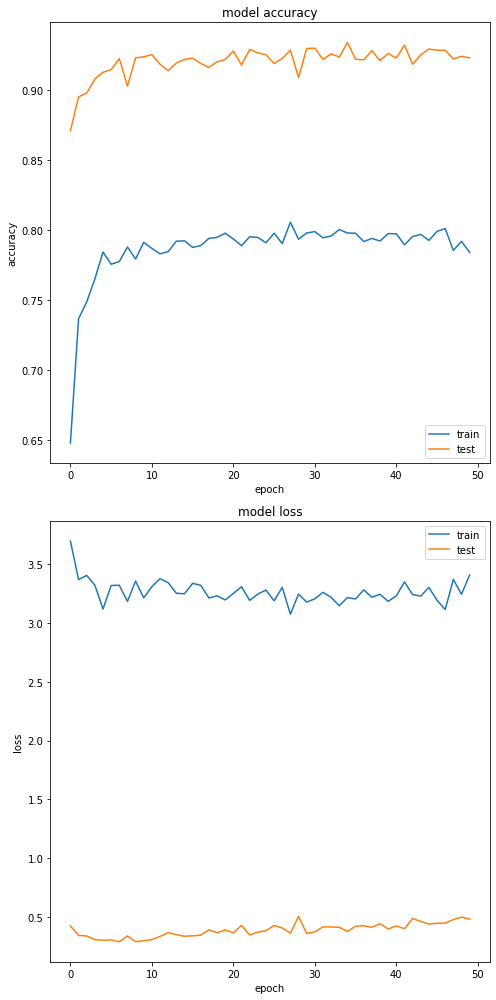

In [180]:
#Treinamento

# Salva os melhores resultados
from keras.callbacks import ModelCheckpoint   
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

history = mlp.fit(x_train, tag_train, 128, epochs=50, validation_data=(x_valid, tag_valid), verbose=2, callbacks=[checkpointer])

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [0]:
# Carrega o modelo com os melhores valores
mlp.load_weights('model.weights.best.hdf5')

In [182]:
# Avalia os resultados
# evaluate and print test accuracy
score = mlp.evaluate(x_eval, tag_eval, verbose=2)

print('\n', 'Test accuracy:', score[1])
print("Test loss", score[0])


 Test accuracy: 0.9222857142857143
Test loss 0.2902929732033185


In [183]:
# Predições

predict = mlp.predict(x_eval)

labels = [str(i) for i in range(10)]

print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


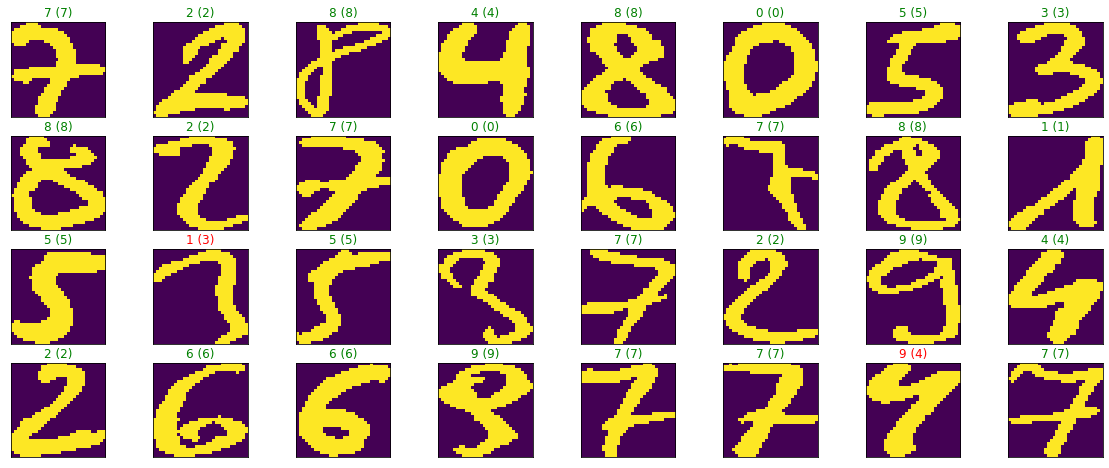

In [184]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_eval.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_eval[idx].reshape(32,32)))
    pred_idx = np.argmax(predict[idx])
    true_idx = np.argmax(tag_eval[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [0]:
# Salva dados do modelo no pc
from google.colab import files

#files.download("model.weights.best.hdf5")

# Classificação dos dígitos


 Test accuracy: 1.0
Test loss 0.010124290362000465


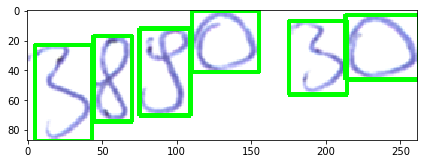

In [204]:
i =  data[0]
digitos = i[6]
# plt.imshow(cv.cvtColor(digitos[0], cv.COLOR_BGR2RGB))
# plt.show()
# print(type(digitos))
# print(len(digitos))
data = np.ndarray((len(digitos), 32*32))
tag = i[7]

labels = [str(i) for i in range(10)]


for j in range(len(digitos)):
    digitos[j] = binarizacao(digitos[j])
    data[j] = (digitos[j].flatten())/255
tag = keras.utils.to_categorical(tag, num_classes)
score = mlp.evaluate(data, tag, verbose=2)

predict = mlp.predict(data)
print('\n', 'Test accuracy:'  , score[1])
print("Test loss", score[0])



final = i[0]
pos = i[4]
color = (0,0,0)
for idx in range(len(tag)):
    pred_idx = np.argmax(predict[idx])
    true_idx = np.argmax(tag[idx])
    if(labels[true_idx] == labels[pred_idx]):
        color = (0,255,0)
    else:
        color = (0,0,255)
    (x, y, w, h) = pos[idx]
    cv.rectangle(final, (x, y), (x + w, y + h), color, 2)
plt.imshow(cv.cvtColor(final, cv.COLOR_BGR2RGB))
plt.show()

# for i in data:
#     digitos = i[6]
#     tag = i[7]
#     for j in range(len(digitos)):
#         digitos[j] = binarizacao(digitos[j])
#         digitos[j] = digitos[j].flatten()
#     try:
#         score = mlp.evaluate(digitos, tag, verbose=2)

#         print('\n', 'Test accuracy:'  , score[1])
#         print("Test loss", score[0])
#     except:
#         print("Erro na execução")